<a href="https://colab.research.google.com/github/pietrodileo/Python_for_MD_thesis/blob/main/TrainCNN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Install, Import, Login

## Import Libraries

In [375]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wave
import pylab
import sys
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
import itertools
import time
import shutil
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [376]:
!pip install -U kaleido
#need to restart runtime after install kaleido
import kaleido
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [377]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 📈 Preparing the data
We can now load the spectrograms into memory. We use the image_dataset_from_directory utility to generate the datasets. The validation set is what will ultimately be our benchmark when becomes to performance and accuracy of our classifier. The seed is for reproducibility.

##Create dataset functions

In [378]:
def createTrain_and_Test_Dataset(directory,BATCH_SIZE,VAL_SPLIT,IMAGE_HEIGHT, IMAGE_WIDTH, MODE):
  # Make a dataset containing the training spectrograms
  train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            directory,
                                            labels='inferred',
                                            class_names = False,
                                            batch_size=BATCH_SIZE,
                                            validation_split=VAL_SPLIT,
                                            subset='training',
                                            shuffle=True,
                                            color_mode= MODE,
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)

  # Make a dataset containing the validation spectrogram
  valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            directory,
                                            labels='inferred',
                                            class_names = False,
                                            batch_size=BATCH_SIZE,
                                            validation_split=VAL_SPLIT,
                                            subset='validation',
                                            shuffle=True,
                                            color_mode= MODE,
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            seed=0)
  return train_dataset, valid_dataset

Before we can build our model and start training, we need to apply one simple augmentation the dataset and that is rescaling. We convert input from int to float32 and rescale it from the (0, 255) range to the (0,1) range.

## Rescale data size as [256, 256]

In [379]:
# Function to prepare our datasets for modelling
def prepare(batches):

  def normalize(img, label):
    return img / 255.0, label

  ds = (batches
        .map(normalize)
        .prefetch(tf.data.AUTOTUNE)
        ) 
  return ds

# ⏰ Execution time

In [380]:
start_time = time.time()

# 🧠 Define the Model and Train

## Define Model Architecture 🦾

In [381]:
def make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES, num_cnn_layers):
  # Create CNN model with 3 Convolution Layer Architecture
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
  # Conv2D(NumFilter, FilterSize, option...)
  # # 1
  # model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')) #kernel_initializer='he_uniform'
  # model.add(tf.keras.layers.BatchNormalization())
  # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  # model.add(tf.keras.layers.BatchNormalization())
  # # 2
  # model.add(tf.keras.layers.Conv2D(64, (3, 3),strides=(1, 1), padding='same', activation='relu'))
  # model.add(tf.keras.layers.BatchNormalization())
  # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  # model.add(tf.keras.layers.BatchNormalization())
  # # # 3
  # model.add(tf.keras.layers.Conv2D(128, (3, 3),strides=(1, 1), padding='same', activation='relu'))
  # model.add(tf.keras.layers.BatchNormalization())
  # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  # model.add(tf.keras.layers.BatchNormalization())
  # # # 4
  # model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))
  # model.add(tf.keras.layers.BatchNormalization())
  # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  # model.add(tf.keras.layers.BatchNormalization())

  NUM_FILTERS = 32
  for i in range(1, num_cnn_layers+1):
    model.add(tf.keras.layers.Conv2D(NUM_FILTERS*i, (3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

  # flattening
  model.add(tf.keras.layers.Flatten())
  # NN 
  model.add(tf.keras.layers.Dense(256, activation='relu')) 
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
  return model

## Plot results function

In [382]:
def plotResults(history,SaveFile,outputPath):
  # Plot the loss curves for training and validation.
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values)+1)
  
  d = {'Train Loss': loss_values, 'Test Loss': val_loss_values, 'Epochs':epochs}
  df = pd.DataFrame(d)
  
  fig = go.Figure()
  fig = make_subplots(rows=2, cols=1,
                      subplot_titles=("Training and Validation Loss", "Training and Validation Accuracy"))

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Train Loss'],
      name="Training Loss",       # this sets its legend entry
      mode='lines+markers'
  ),1,1),

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Test Loss'],
      name="Validation Loss",
      mode='lines+markers'
  ),1,1),

  # Plot the accuracy curves for training and validation.
  acc_values = history_dict['accuracy']
  val_acc_values = history_dict['val_accuracy']
  epochs = range(1, len(acc_values)+1)

  d = {'Train Accuracy': acc_values, 'Test Accuracy': val_acc_values, 'Epochs':epochs}
  df = pd.DataFrame(d)

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Train Accuracy'],
      name="Training Accuracy",       # this sets its legend entry
      mode='lines+markers'
  ),2,1),

  fig.append_trace(go.Scatter(
      x=df['Epochs'],
      y=df['Test Accuracy'],
      name="Validation Accuracy",
      mode='lines+markers'
  ),2,1),

  # edit axis labels
  fig['layout']['xaxis']['title']='Epochs'
  fig['layout']['xaxis2']['title']='Epochs'
  fig['layout']['yaxis']['title']='Loss'
  fig['layout']['yaxis2']['title']='Accuracy'

  # Tick Distance
  fig['layout']['xaxis']['dtick']= 5
  fig['layout']['xaxis2']['dtick']= 5
  # First value on x axis
  fig['layout']['xaxis']['tick0']= 0
  fig['layout']['xaxis2']['tick0']= 0
  # Tick Mode
  fig['layout']['xaxis']['tickmode']= 'linear'
  fig['layout']['xaxis2']['tickmode']= 'linear'

  fig.update_layout(
      height=800, 
      width=1200,
      title="Loss and Accuracy",
      legend_title="Dataset",
      font=dict(size=14)
  )

  return fig, loss_values, val_loss_values, acc_values, val_acc_values

# 3. 🛫 Compute Code

## Define Parameters for Training

In [383]:
#@title Declare Constants
#@markdown ---
fileName = 'C18' #@param {type: "string"}
num_cnn_layers = 4 #@param {type: "number"}
IMAGE_HEIGHT = 256 #@param {type: "number"}
IMAGE_WIDTH = 256 #@param {type: "number"}
BATCH_SIZE = 32 #@param {type: "slider", min: 1, max: 256}
EPOCHS = 100  #@param {type: "number"}
VAL_SPLIT = 0.2  #@param {type: "slider", min: 0, max: 1, step:0.05}
MODE = "grayscale"  #@param ['rgb', 'rgba', 'grayscale']
SaveFile = True #@param {type: "boolean"}
#@markdown ---

##Select Input and Output ⏏

Speed up Google Colab by copying the zip file containing the images directly on the local path (75% faster). 

In [384]:
TASK = str(EPOCHS) + 'EP_' + str(num_cnn_layers) + 'conv_' + 'Batch' + str(BATCH_SIZE) + '_adam_' + fileName  
TASK

'100EP_4conv_Batch32_adam_C18'

In [385]:
zipfile = fileName + '.zip'
directory = '/content/drive/MyDrive/TesiMagistrale/outputSpectrogram/CNN_TrainingIMGs/BW/'

zipPath = os.path.join(directory,zipfile)
outputDir = os.path.join(directory,'Risultati')
outputPath = os.path.join(outputDir,TASK)

if not os.path.exists(outputPath):
   # Create a new directory because it does not exist
   os.makedirs(outputPath)
   print("The output folder has been created!")

# Location of Zip File
drive_path = zipPath
local_path = '/content'

zipCopyPath = os.path.join(local_path,zipfile)
if not os.path.exists(zipCopyPath):
  # Copy the zip file and move it up one level (AKA out of the drive folder)
  !cp '{drive_path}' .
else:
  print('Files already transferred from Drive')

if not os.path.exists(fileName):
  # Navigate to the copied file and unzip it quietly
  os.chdir(local_path)
  !unzip -q '{zipfile}'
else:
  print('Files already unzipped')
# change directory to the new one
NewDir = os.path.join(local_path,fileName)

The output folder has been created!


##Select channels and classes, split the dataset

In [386]:
# Select number of channels
if MODE == 'grayscale':
  N_CHANNELS = 1
elif MODE == 'rgb':
  N_CHANNELS = 3
elif MODE == 'rgba':
  N_CHANNELS = 4

# Create the dataset and select number of classes
[train_batches, valid_batches] = createTrain_and_Test_Dataset(NewDir,BATCH_SIZE,VAL_SPLIT,IMAGE_HEIGHT, IMAGE_WIDTH, MODE)

classNames = train_batches.class_names
N_CLASSES = len(classNames)

# Extract image path for training and validation set
image_paths_train = train_batches.file_paths
image_paths_valid = valid_batches.file_paths

train_dataset = prepare(train_batches)
valid_dataset = prepare(valid_batches)

LabelNames = valid_batches.class_names
LabelNames

Found 2240 files belonging to 4 classes.
Using 1792 files for training.
Found 2240 files belonging to 4 classes.
Using 448 files for validation.


['class_DBS-onon',
 'class_Early_PD',
 'class_HealthyControl',
 'class_advanced_PD-OFF']

## Set Optimizer and Loss Function ♟
### LOSS FUNCTION
see: 
* tf.keras.losses

### OPTIMIZERS 
See: 
* tf.keras.optimizers.RMSprop()
* tf.keras.optimizers.SGD
* tf.keras.optimizers.Adam

We introduce **Early Stopping**, which has the following parameters:
* min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
* patience: Number of epochs with no improvement after which training will be stopped
* mode: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
* baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
* restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set.

We also introduce **ModelCheckpoint**, which save in a specified path the model that achieved the best results and **ReduceLROnPlateau**, which reduce learning rate when a metric has stopped improving.




In [387]:
monitorValue = 'val_loss'
monitorMode = 'min'

checkpoint_path = os.path.join(outputPath,'training_1/cp.ckpt')
bestModelName = os.path.join(outputPath,'best_mdl.h5')
earlyStopping = EarlyStopping(monitor=monitorValue, 
                              patience=40, 
                              verbose=0, 
                              mode=monitorMode,
                              restore_best_weights=True)

mcp_save = ModelCheckpoint(filepath=checkpoint_path,
                           save_best_only=True, 
                           monitor=monitorValue, 
                           mode=monitorMode)

reduce_lr_loss = ReduceLROnPlateau(monitor=monitorValue,
                                   factor=0.1, patience=5, 
                                   verbose=0, min_delta=1e-4, mode=monitorMode)

LOSS = 'sparse_categorical_crossentropy'

# OPTIMIZER = tf.keras.optimizers.SGD(
#         learning_rate=0.01,
#         momentum=0.0,
#         nesterov=False,
#         name='SGD')

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Train the network 💪


### Make Model

In [388]:
model = make_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES, num_cnn_layers)
# Compile model
model.compile(
    loss = LOSS,
    optimizer = OPTIMIZER,
    metrics=['accuracy'])

### Train Model

In [389]:
# Train model and capture the history
history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data = valid_dataset,
                    callbacks = [earlyStopping, mcp_save, reduce_lr_loss]
                    )

Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 1.4199 - accuracy: 0.5100

56/56 [==============================] - 62s 969ms/step - loss: 1.4199 - accuracy: 0.5100 - val_loss: 1.8852 - val_accuracy: 0.2433 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.7294

56/56 [==============================] - 47s 763ms/step - loss: 0.7026 - accuracy: 0.7294 - val_loss: 1.7930 - val_accuracy: 0.3013 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - 41s 652ms/step - loss: 0.4216 - accuracy: 0.8504 - val_loss: 1.8638 - val_accuracy: 0.3058 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - 41s 625ms/step - loss: 0.2679 - accuracy: 0.9062 - val_loss: 2.0125 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/100
56/56 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9520

56/56 [==============================] - 46s 747ms/step - loss: 0.1422 - accuracy: 0.9520 - val_loss: 1.5306 - val_accuracy: 0.3996 - lr: 0.0010
Epoch 6/100
56/56 [==============================] - 41s 656ms/step - loss: 0.0928 - accuracy: 0.9727 - val_loss: 1.8462 - val_accuracy: 0.4353 - lr: 0.0010
Epoch 7/100
56/56 [==============================] - 42s 656ms/step - loss: 0.0667 - accuracy: 0.9777 - val_loss: 2.6664 - val_accuracy: 0.3772 - lr: 0.0010
Epoch 8/100
56/56 [==============================] - 39s 621ms/step - loss: 0.0426 - accuracy: 0.9905 - val_loss: 2.4303 - val_accuracy: 0.4018 - lr: 0.0010
Epoch 9/100
56/56 [==============================] - 41s 659ms/step - loss: 0.0463 - accuracy: 0.9872 - val_loss: 1.8780 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 10/100
56/56 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9877

56/56 [==============================] - 45s 734ms/step - loss: 0.0397 - accuracy: 0.9877 - val_loss: 0.7686 - val_accuracy: 0.6942 - lr: 0.0010
Epoch 11/100
56/56 [==============================] - 42s 644ms/step - loss: 0.0322 - accuracy: 0.9927 - val_loss: 1.4693 - val_accuracy: 0.5402 - lr: 0.0010
Epoch 12/100
56/56 [==============================] - 38s 603ms/step - loss: 0.0267 - accuracy: 0.9927 - val_loss: 0.7702 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 13/100
56/56 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9972

56/56 [==============================] - 45s 710ms/step - loss: 0.0170 - accuracy: 0.9972 - val_loss: 0.2846 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 14/100
56/56 [==============================] - 42s 667ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.3122 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 15/100
56/56 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

56/56 [==============================] - 43s 696ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2164 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 16/100
56/56 [==============================] - 42s 671ms/step - loss: 0.0107 - accuracy: 0.9972 - val_loss: 0.2211 - val_accuracy: 0.9263 - lr: 0.0010
Epoch 17/100
56/56 [==============================] - 41s 652ms/step - loss: 0.0094 - accuracy: 0.9989 - val_loss: 0.2302 - val_accuracy: 0.9196 - lr: 0.0010
Epoch 18/100
56/56 [==============================] - 41s 664ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.2383 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 19/100
56/56 [==============================] - 38s 603ms/step - loss: 0.0068 - accuracy: 0.9994 - val_loss: 0.2628 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 20/100
56/56 [==============================] - 40s 637ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.3957 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 21/100
56/56 [==============================] - ETA: 0s - l

56/56 [==============================] - 47s 759ms/step - loss: 0.0065 - accuracy: 0.9989 - val_loss: 0.1696 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 22/100
56/56 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994

56/56 [==============================] - 44s 713ms/step - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.1446 - val_accuracy: 0.9442 - lr: 1.0000e-04
Epoch 23/100
56/56 [==============================] - 40s 645ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.1492 - val_accuracy: 0.9464 - lr: 1.0000e-04
Epoch 24/100
56/56 [==============================] - 38s 607ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1472 - val_accuracy: 0.9487 - lr: 1.0000e-04
Epoch 25/100
56/56 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

56/56 [==============================] - 45s 695ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.1425 - val_accuracy: 0.9442 - lr: 1.0000e-04
Epoch 26/100
56/56 [==============================] - 39s 616ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1490 - val_accuracy: 0.9442 - lr: 1.0000e-04
Epoch 27/100
56/56 [==============================] - 40s 644ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1473 - val_accuracy: 0.9442 - lr: 1.0000e-04
Epoch 28/100
56/56 [==============================] - 39s 611ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1482 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 29/100
56/56 [==============================] - 41s 649ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1488 - val_accuracy: 0.9464 - lr: 1.0000e-04
Epoch 30/100
56/56 [==============================] - 38s 611ms/step - loss: 9.7601e-04 - accuracy: 1.0000 - val_loss: 0.1469 - val_accuracy: 0.9464 - lr: 1.0000e-04
Epoch 31/100
56/56 [=================

## Plot results 🛬 

In [390]:
fig, loss_values, val_loss_values, acc_values, val_acc_values = plotResults(history,SaveFile,outputPath)
fig.show()

## Save plot

In [391]:
# Save pic in HTML
if SaveFile == True:
  AccLossPngOutput = os.path.join(outputPath,'results.html')
  fig.write_html(AccLossPngOutput)
  print('Image Saved')

Image Saved


In [392]:
# Convert HTML in PNG and export to Google Drive
resultImg = f"{outputPath}"+'/results.png'
fig.to_image(format="png", engine="kaleido");
fig.write_image(resultImg)

##Export Results to Google Drive 💯

Save the best model

In [393]:
model.save(bestModelName)

Import a previous model

In [394]:
model = tf.keras.models.load_model(bestModelName)

Compute the final loss and accuracy

In [395]:
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.142466, final accuracy: 0.944196


Compute runtime

In [396]:
runtime = time.time() - start_time

print('Runtime:')
print("--- %s seconds ---" % (runtime))
print("--- %s minutes ---" % ((runtime)/60))

Runtime:
--- 3283.31853222847 seconds ---
--- 54.72197553714116 minutes ---


In [397]:
# dictionary of lists  
InfoDict = {'IMAGE_HEIGHT':[IMAGE_HEIGHT], 'IMAGE_WIDTH':[IMAGE_WIDTH],
              'BATCH_SIZE': [BATCH_SIZE], 'N_CHANNELS': [N_CHANNELS], 'N_CLASSES': [N_CLASSES],
              'EPOCHS':[EPOCHS], 'VAL_SPLIT': [VAL_SPLIT], 'MODE': MODE,
              'FINAL VALIDATION LOSS': [final_loss], 'FINAL VALIDATION ACC': [final_acc],
              'RUNTIME (s)': [runtime], 'RUNTIME (min)': [runtime/60]
              }
InfoDict
dfInfo = pd.DataFrame(InfoDict)
dfInfo.index = ['CNN']
# saving the dataframe 
outputName = 'Model_Info_and_Performance.xlsx'
OutputFileName = os.path.join(outputPath,outputName)
if SaveFile == True:
  # writing to Excel
  dfInfo.to_excel(OutputFileName)

In [398]:
# dictionary of lists  
OutputDict = {'Train_ACC':acc_values, 'Train_LOSS':loss_values, 
              'Test_ACC': val_acc_values, 'Test_LOSS': val_loss_values}
dfResult = pd.DataFrame(OutputDict) 
# saving the dataframe 
outputName = 'Risultati'
OutputFileName = outputPath+'/'+outputName+'.xlsx'
dfResult.to_excel(OutputFileName) 

In [399]:
Summary = os.path.join(outputPath,'modelsummary.txt')
modelInfo = model.summary()

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

with open(Summary, 'w') as f:
  # Pass the file handle in as a lambda function to make it callable
  f.write(short_model_summary)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_9 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                                                      

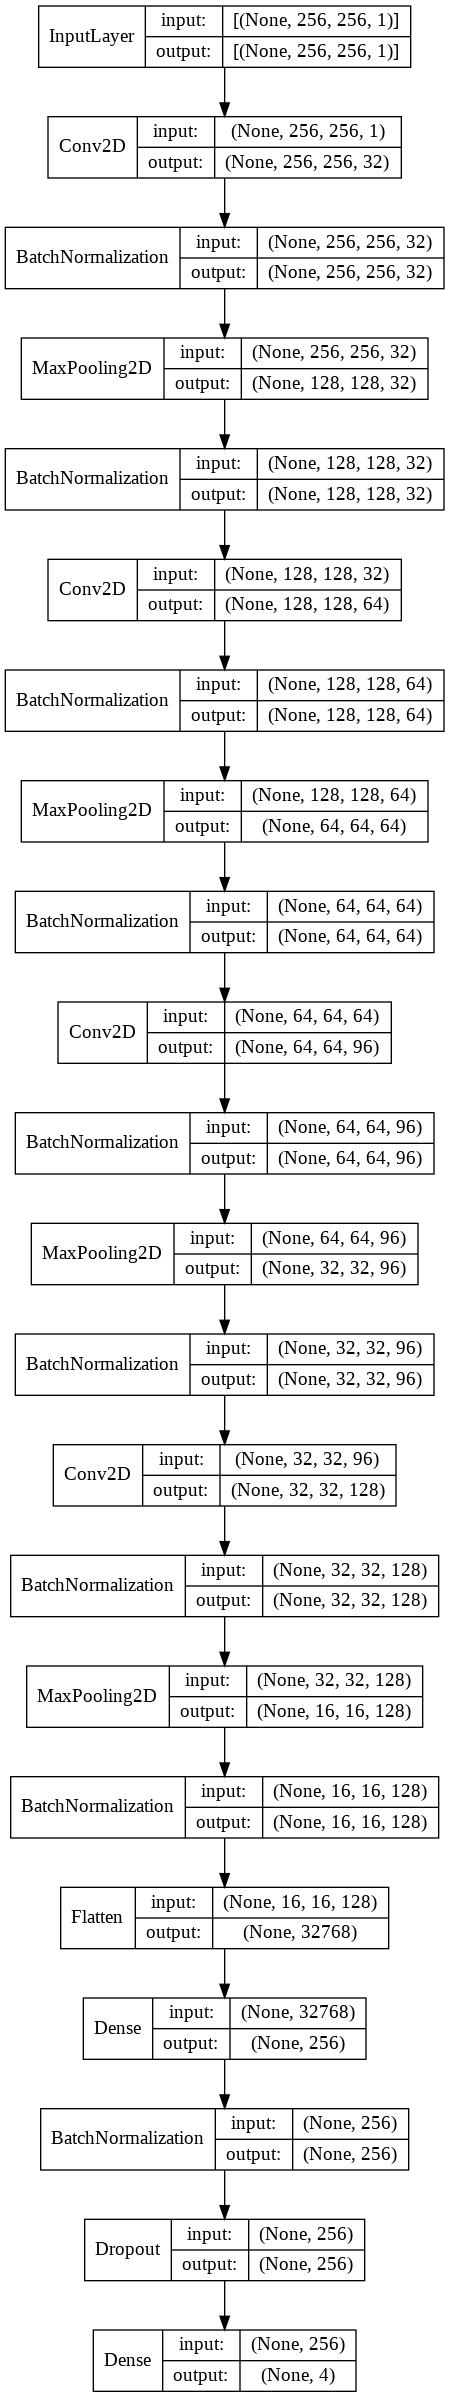

In [400]:
pngOutput = os.path.join(outputPath,'model_plot.png')
plot_model(model, to_file=pngOutput, show_shapes=True, show_layer_names=False)

## Confusion Matrix

In [401]:
def Evaluate_Batches(batch_dataset):
  #extract the labels of each batch
  true_labels = []
  pred_labels = [] 
  train_labels = []
  for image_batch, label_batch in batch_dataset:
    # image_batch contains n figure, where n is batch size.  
    # It's an EagerTensor with a shape of (n, ImHeight, ImWidth, Nchannels)
    preds = model.predict(image_batch,verbose=0)
    # preds is a ndarray with n rows and N_CLASSES columns
    # it is the output of the last neurons of the Dens/softmax Layer
    pred_labels += np.argmax(preds, axis = - 1).tolist()
    train_labels += label_batch.numpy().tolist()
    # Alternative Code (use EagerTensor, a bit longer) 
    # pred_labels.append(np.argmax(preds, axis = - 1))
    # pred_labels is a list of which each element is an ndarray with size n (batchsize)
    # This list is composed by M elements, where M is the number of batch 
  return train_labels, pred_labels

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=13)
        plt.yticks(tick_marks, target_names, fontsize=13)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     size='xx-large',
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]), 
                     size='xx-large',
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontsize=14)
    plt.show()    

def ConfMtxPlot(train_labels, pred_labels):
  confusion_mtx = confusion_matrix(train_labels, pred_labels) 
  # plot the confusion matrix
  f,ax = plt.subplots(figsize=(8, 7))
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.1,cmap="Blues",linecolor="k", fmt= '.0f',ax=ax,cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

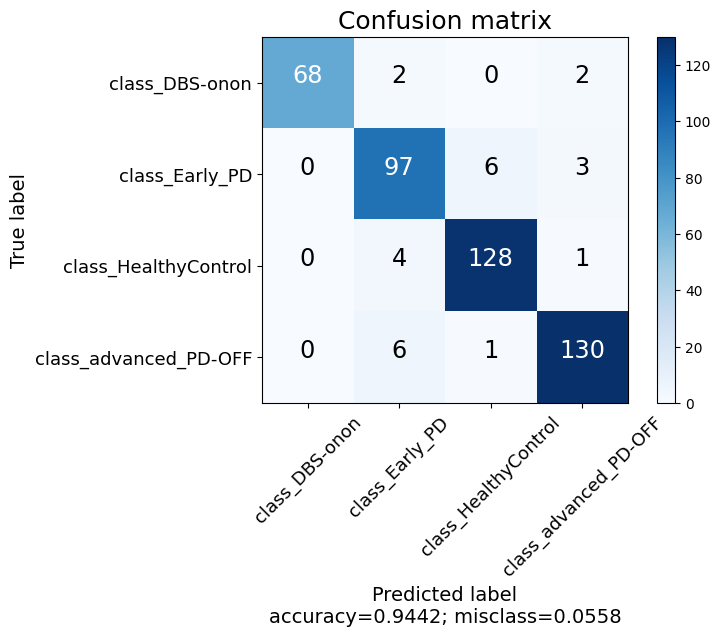

In [402]:
pred_labels, true_labels = Evaluate_Batches(valid_dataset)
confusion_mtx = confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(confusion_mtx,
                          LabelNames,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

## Plot the loss and accuracy curves for training and validation 


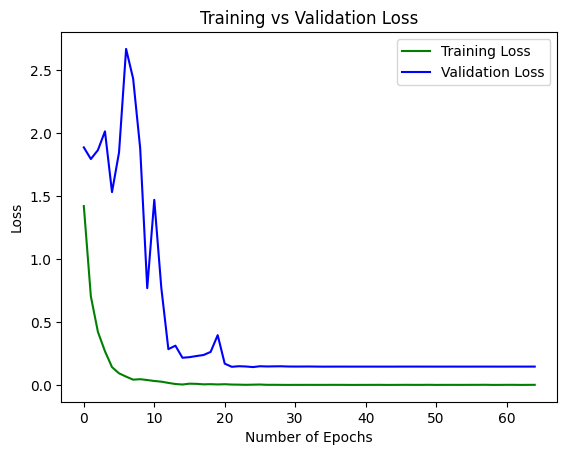

In [403]:
plt.plot(history.history['loss'], color='g', label="Training Loss")
plt.plot(history.history['val_loss'], color='b', label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [404]:
from sklearn.metrics import classification_report, roc_curve, auc
print(classification_report(true_labels, pred_labels, target_names = LabelNames))

                       precision    recall  f1-score   support

       class_DBS-onon       1.00      0.94      0.97        72
       class_Early_PD       0.89      0.92      0.90       106
 class_HealthyControl       0.95      0.96      0.96       133
class_advanced_PD-OFF       0.96      0.95      0.95       137

             accuracy                           0.94       448
            macro avg       0.95      0.94      0.95       448
         weighted avg       0.95      0.94      0.94       448



ROC Curve

In [406]:
from sklearn.metrics import roc_curve, auc

if len(LabelNames) == 2:
  FPR, TPR, ROC_Thresholds = roc_curve(true_labels, pred_labels)
  AUC = auc(FPR, TPR)
  
  plt.figure()
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(FPR, TPR, label='AUC = {:.3f}'.format(AUC))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

Statistics for Binary classifications

In [411]:
PositiveClass = 1 # select positive class (disease), 0 or 1, in binary classification

if len(LabelNames) == 2:
  if PositiveClass == 0:
    TP = confusion_mtx[0,0]
    FP = confusion_mtx[0,1]
    FN = confusion_mtx[1,0]
    TN = confusion_mtx[1,1]
  else:
    TN = confusion_mtx[0,0]
    FN = confusion_mtx[0,1]
    FP = confusion_mtx[1,0]
    TP = confusion_mtx[1,1]
  
  Accuracy = (TP+TN)/(TP+TN+FP+FN);
  Miscl_Rate = 1-Accuracy;
  PPV = TP/(TP+FP); # also called Precision
  NPV = TN/(TN+FN);
  Sensitivity = TP/(TP+FN); # Or Recall, True Positive Rate
  Specificity = TN/(TN+FP); # True Negative Rate
  J = Sensitivity+Specificity-1;
  F1score = 2*((PPV*Sensitivity)/(PPV + Sensitivity));
  Gmean = np.sqrt(Sensitivity*Specificity);

  true_labels = np.array(true_labels)
  pred_labels = np.array(pred_labels)
  errors = true_labels != pred_labels
  errorsNum = sum(errors)

  StatLabels = ["Accuracy","Misclassification Rate","PPV","NPV","Sensitivity",
                "Specificity","AUC","Youden's Index",
                "F1-score","G-Mean","Runtime (s)"]

  StatArray = np.array([Accuracy,Miscl_Rate,PPV,NPV,Sensitivity,Specificity,
               AUC,J,F1score,Gmean, runtime])

  Stat_df = pd.DataFrame(StatArray)#,columns=StatLabels)
  Stat_df = pd.DataFrame.transpose(Stat_df)
  Stat_df.columns = StatLabels
  Stat_df.index = ['Statistics']
  Stat_df
else:
  # Multiclass Classification
  report = classification_report(true_labels, pred_labels, target_names = LabelNames,output_dict=True)
  reportdf = pd.DataFrame(report).transpose()
  reportdf
# dfResult = pd.DataFrame(OutputDict) 
# # saving the dataframe 
# outputName = 'Risultati'
# OutputFileName = outputPath+'/'+outputName+'.xlsx'
# dfResult.to_excel(OutputFileName) 

# Visualize Feature Map

In [449]:
import PIL
import PIL.Image

# Preprocesses the image into a 4D tensor
img_path = '/content/C1/class_advanced_PD-OFF/PD_OFF_TesiPDL_VowelE_0011_FineCut_Short_regular.png'
img = tf.keras.preprocessing.image.load_img(img_path,color_mode='grayscale')
img = np.array(img)
print(img.shape)
img = np.expand_dims(img, axis=-1)
print(img.shape)
img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
print(img.shape)
img_tensor = np.expand_dims(img, axis=0)
print(img.shape)
img_tensor = img_tensor / 255.0


(1087, 1116)
(1087, 1116, 1)
(256, 256, 1)
(256, 256, 1)


In [450]:
# create a feature map model
layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
feature_maps = feature_map_model.predict(img_tensor)
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

1/1 [==============================] - 0s 303ms/step
The shape of the conv2d_4 is =======>> (1, 256, 256, 32)
The shape of the batch_normalization_9 is =======>> (1, 256, 256, 32)
The shape of the max_pooling2d_4 is =======>> (1, 128, 128, 32)
The shape of the batch_normalization_10 is =======>> (1, 128, 128, 32)
The shape of the conv2d_5 is =======>> (1, 128, 128, 64)
The shape of the batch_normalization_11 is =======>> (1, 128, 128, 64)
The shape of the max_pooling2d_5 is =======>> (1, 64, 64, 64)
The shape of the batch_normalization_12 is =======>> (1, 64, 64, 64)
The shape of the conv2d_6 is =======>> (1, 64, 64, 96)
The shape of the batch_normalization_13 is =======>> (1, 64, 64, 96)
The shape of the max_pooling2d_6 is =======>> (1, 32, 32, 96)
The shape of the batch_normalization_14 is =======>> (1, 32, 32, 96)
The shape of the conv2d_7 is =======>> (1, 32, 32, 128)
The shape of the batch_normalization_15 is =======>> (1, 32, 32, 128)
The shape of the max_pooling2d_7 is =======>>

(1, 256, 256, 32)
(1, 128, 128, 64)
(1, 64, 64, 96)
(1, 32, 32, 128)


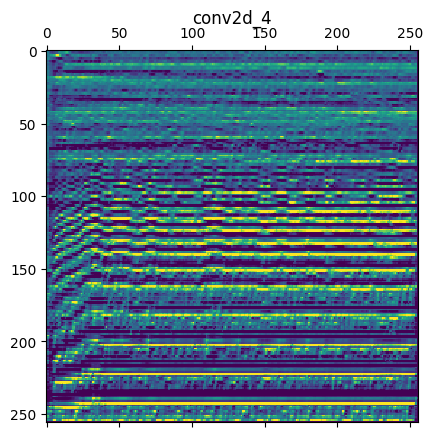

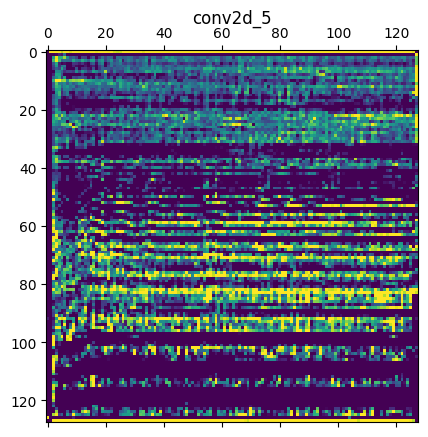

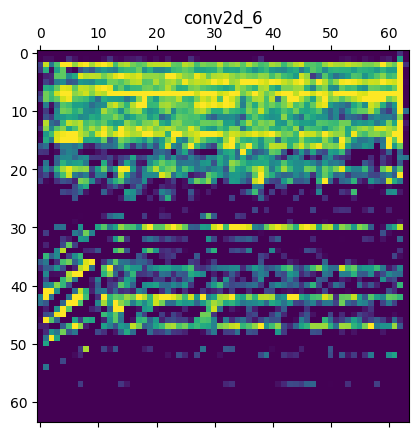

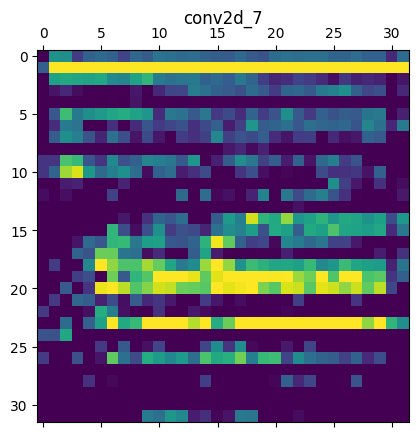

In [451]:
for i in range(0,len(layer_names)):
  lName = layer_names[i]
  if 'conv' in lName:
    layer_activation = feature_maps[i]
    print(layer_activation.shape)
    channel = 0
    # Let’s try plotting the fifth channel of the activation of the first layer of the original model
    channel_image = layer_activation[0, :, :, channel]
    channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
    channel_image /= channel_image.std()
    channel_image *= 64
    channel_image += 128
    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
    plt.matshow(channel_image, cmap='viridis')
    plt.title(lName)
    plt.savefig(os.path.join(outputPath, 'FeatureMap' + layer_name + '_singlechannel' + '.png'),
                bbox_inches='tight', pad_inches=0)

In [ ]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, feature_maps): # Displays the feature maps
  n_features = layer_activation.shape[-1] # Number of features in the feature map
  size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
  n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  if 'conv' in layer_name:
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.savefig(os.path.join(outputPath, 'FeatureMap' + layer_name + '.png'),
              bbox_inches='tight', pad_inches=0)

# GRADCAM Sensitivity/Activation Map

In [417]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 990ms/step
Predicted: class_advanced_PD-OFF


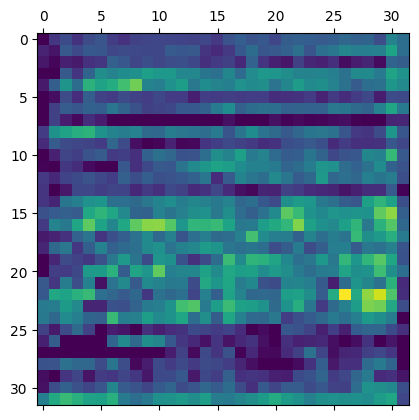

In [418]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_tensor)
predsL = np.array(preds)[0].tolist()
prediction = np.max(predsL)
predIdx = predsL.index(prediction)
predictedClass = LabelNames[predIdx]

print("Predicted:", predictedClass)

for i in range(0,len(layer_names)):
  lName = layer_names[i]
  if 'conv' in lName:
    last_conv_layer_name = lName

# Generate c)lass activation heatmap
heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

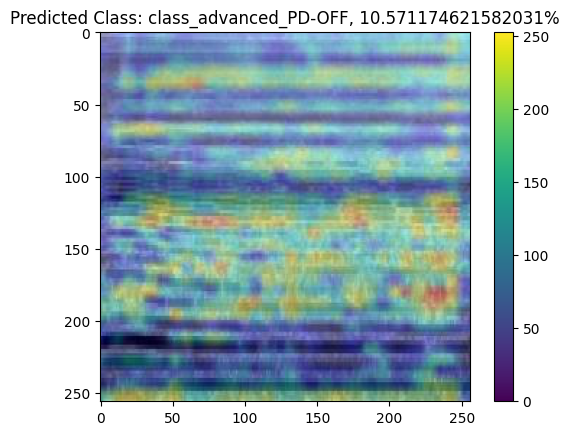

In [434]:
# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

cam_path="GradCam_SensitivityMap.jpg"
alpha=0.5

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * alpha + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
superimposed_img.save(cam_path)

# Display Grad CAM
GradCamImg = mpimg.imread(cam_path)
imgplot = plt.imshow(GradCamImg)
plt.title('Predicted Class: '+ predictedClass+ ', '+ str(prediction) +'%')
plt.colorbar()
plt.show()

# Plot Model Structure

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:235: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



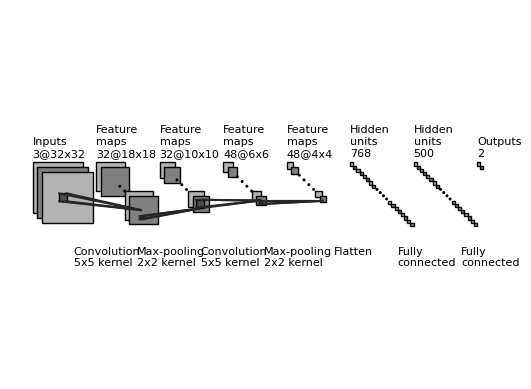

In [420]:
"""
Copyright (c) 2017, Gavin Weiguang Ding
All rights reserved.
Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are met:
1. Redistributions of source code must retain the above copyright notice, this
    list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice,
    this list of conditions and the following disclaimer in the documentation
    and/or other materials provided with the distribution.
3. Neither the name of the copyright holder nor the names of its contributors
    may be used to endorse or promote products derived from this software
    without specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
    AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
    IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
    ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
    LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
    CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
    SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
    INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
    CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
    ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
    POSSIBILITY OF SUCH DAMAGE.
"""


import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

NumDots = 4
NumConvMax = 8
NumFcMax = 20
White = 1.
Light = 0.7
Medium = 0.5
Dark = 0.3
Darker = 0.15
Black = 0.


def add_layer(patches, colors, size=(24, 24), num=5,
              top_left=[0, 0],
              loc_diff=[3, -3],
              ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    for ind in range(num):
        patches.append(Rectangle(loc_start + ind * loc_diff, size[1], size[0]))
        if ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_layer_with_omission(patches, colors, size=(24, 24),
                            num=5, num_max=8,
                            num_dots=4,
                            top_left=[0, 0],
                            loc_diff=[3, -3],
                            ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    this_num = min(num, num_max)
    start_omit = (this_num - num_dots) // 2
    end_omit = this_num - start_omit
    start_omit -= 1
    for ind in range(this_num):
        if (num > num_max) and (start_omit < ind < end_omit):
            omit = True
        else:
            omit = False

        if omit:
            patches.append(
                Circle(loc_start + ind * loc_diff + np.array(size) / 2, 0.5))
        else:
            patches.append(Rectangle(loc_start + ind * loc_diff,
                                     size[1], size[0]))

        if omit:
            colors.append(Black)
        elif ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_mapping(patches, colors, start_ratio, end_ratio, patch_size, ind_bgn,
                top_left_list, loc_diff_list, num_show_list, size_list):

    start_loc = top_left_list[ind_bgn] \
        + (num_show_list[ind_bgn] - 1) * np.array(loc_diff_list[ind_bgn]) \
        + np.array([start_ratio[0] * (size_list[ind_bgn][1] - patch_size[1]),
                    - start_ratio[1] * (size_list[ind_bgn][0] - patch_size[0])]
                   )




    end_loc = top_left_list[ind_bgn + 1] \
        + (num_show_list[ind_bgn + 1] - 1) * np.array(
            loc_diff_list[ind_bgn + 1]) \
        + np.array([end_ratio[0] * size_list[ind_bgn + 1][1],
                    - end_ratio[1] * size_list[ind_bgn + 1][0]])


    patches.append(Rectangle(start_loc, patch_size[1], -patch_size[0]))
    colors.append(Dark)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)



def label(xy, text, xy_off=[0, 4]):
    plt.text(xy[0] + xy_off[0], xy[1] + xy_off[1], text,
             family='sans-serif', size=8)


if __name__ == '__main__':

    fc_unit_size = 2
    layer_width = 40
    flag_omit = True

    patches = []
    colors = []

    fig, ax = plt.subplots()


    ############################
    # conv layers
    size_list = [(32, 32), (18, 18), (10, 10), (6, 6), (4, 4)]
    num_list = [3, 32, 32, 48, 48]
    x_diff_list = [0, layer_width, layer_width, layer_width, layer_width]
    text_list = ['Inputs'] + ['Feature\nmaps'] * (len(size_list) - 1)
    loc_diff_list = [[3, -3]] * len(size_list)

    num_show_list = list(map(min, num_list, [NumConvMax] * len(num_list)))
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]

    for ind in range(len(size_list)-1,-1,-1):
        if flag_omit:
            add_layer_with_omission(patches, colors, size=size_list[ind],
                                    num=num_list[ind],
                                    num_max=NumConvMax,
                                    num_dots=NumDots,
                                    top_left=top_left_list[ind],
                                    loc_diff=loc_diff_list[ind])
        else:
            add_layer(patches, colors, size=size_list[ind],
                      num=num_show_list[ind],
                      top_left=top_left_list[ind], loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}@{}x{}'.format(
            num_list[ind], size_list[ind][0], size_list[ind][1]))

    ############################
    # in between layers
    start_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]
    end_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]
    patch_size_list = [(5, 5), (2, 2), (5, 5), (2, 2)]
    ind_bgn_list = range(len(patch_size_list))
    text_list = ['Convolution', 'Max-pooling', 'Convolution', 'Max-pooling']

    for ind in range(len(patch_size_list)):
        add_mapping(
            patches, colors, start_ratio_list[ind], end_ratio_list[ind],
            patch_size_list[ind], ind,
            top_left_list, loc_diff_list, num_show_list, size_list)
        label(top_left_list[ind], text_list[ind] + '\n{}x{} kernel'.format(
            patch_size_list[ind][0], patch_size_list[ind][1]), xy_off=[26, -65]
        )


    ############################
    # fully connected layers
    size_list = [(fc_unit_size, fc_unit_size)] * 3
    num_list = [768, 500, 2]
    num_show_list = list(map(min, num_list, [NumFcMax] * len(num_list)))
    x_diff_list = [sum(x_diff_list) + layer_width, layer_width, layer_width]
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]
    loc_diff_list = [[fc_unit_size, -fc_unit_size]] * len(top_left_list)
    text_list = ['Hidden\nunits'] * (len(size_list) - 1) + ['Outputs']

    for ind in range(len(size_list)):
        if flag_omit:
            add_layer_with_omission(patches, colors, size=size_list[ind],
                                    num=num_list[ind],
                                    num_max=NumFcMax,
                                    num_dots=NumDots,
                                    top_left=top_left_list[ind],
                                    loc_diff=loc_diff_list[ind])
        else:
            add_layer(patches, colors, size=size_list[ind],
                      num=num_show_list[ind],
                      top_left=top_left_list[ind],
                      loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}'.format(
            num_list[ind]))

    text_list = ['Flatten\n', 'Fully\nconnected', 'Fully\nconnected']

    for ind in range(len(size_list)):
        label(top_left_list[ind], text_list[ind], xy_off=[-10, -65])

    ############################
    for patch, color in zip(patches, colors):
        patch.set_color(color * np.ones(3))
        if isinstance(patch, Line2D):
            ax.add_line(patch)
        else:
            patch.set_edgecolor(Black * np.ones(3))
            ax.add_patch(patch)

    plt.tight_layout()
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    fig.set_size_inches(8, 2.5)

    fig_dir = './'
    fig_ext = '.png'
    fig.savefig(os.path.join(fig_dir, 'convnet_fig' + fig_ext),
                bbox_inches='tight', pad_inches=0)

In [421]:
!pip install visualkeras
import visualkeras
from PIL import ImageFont

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


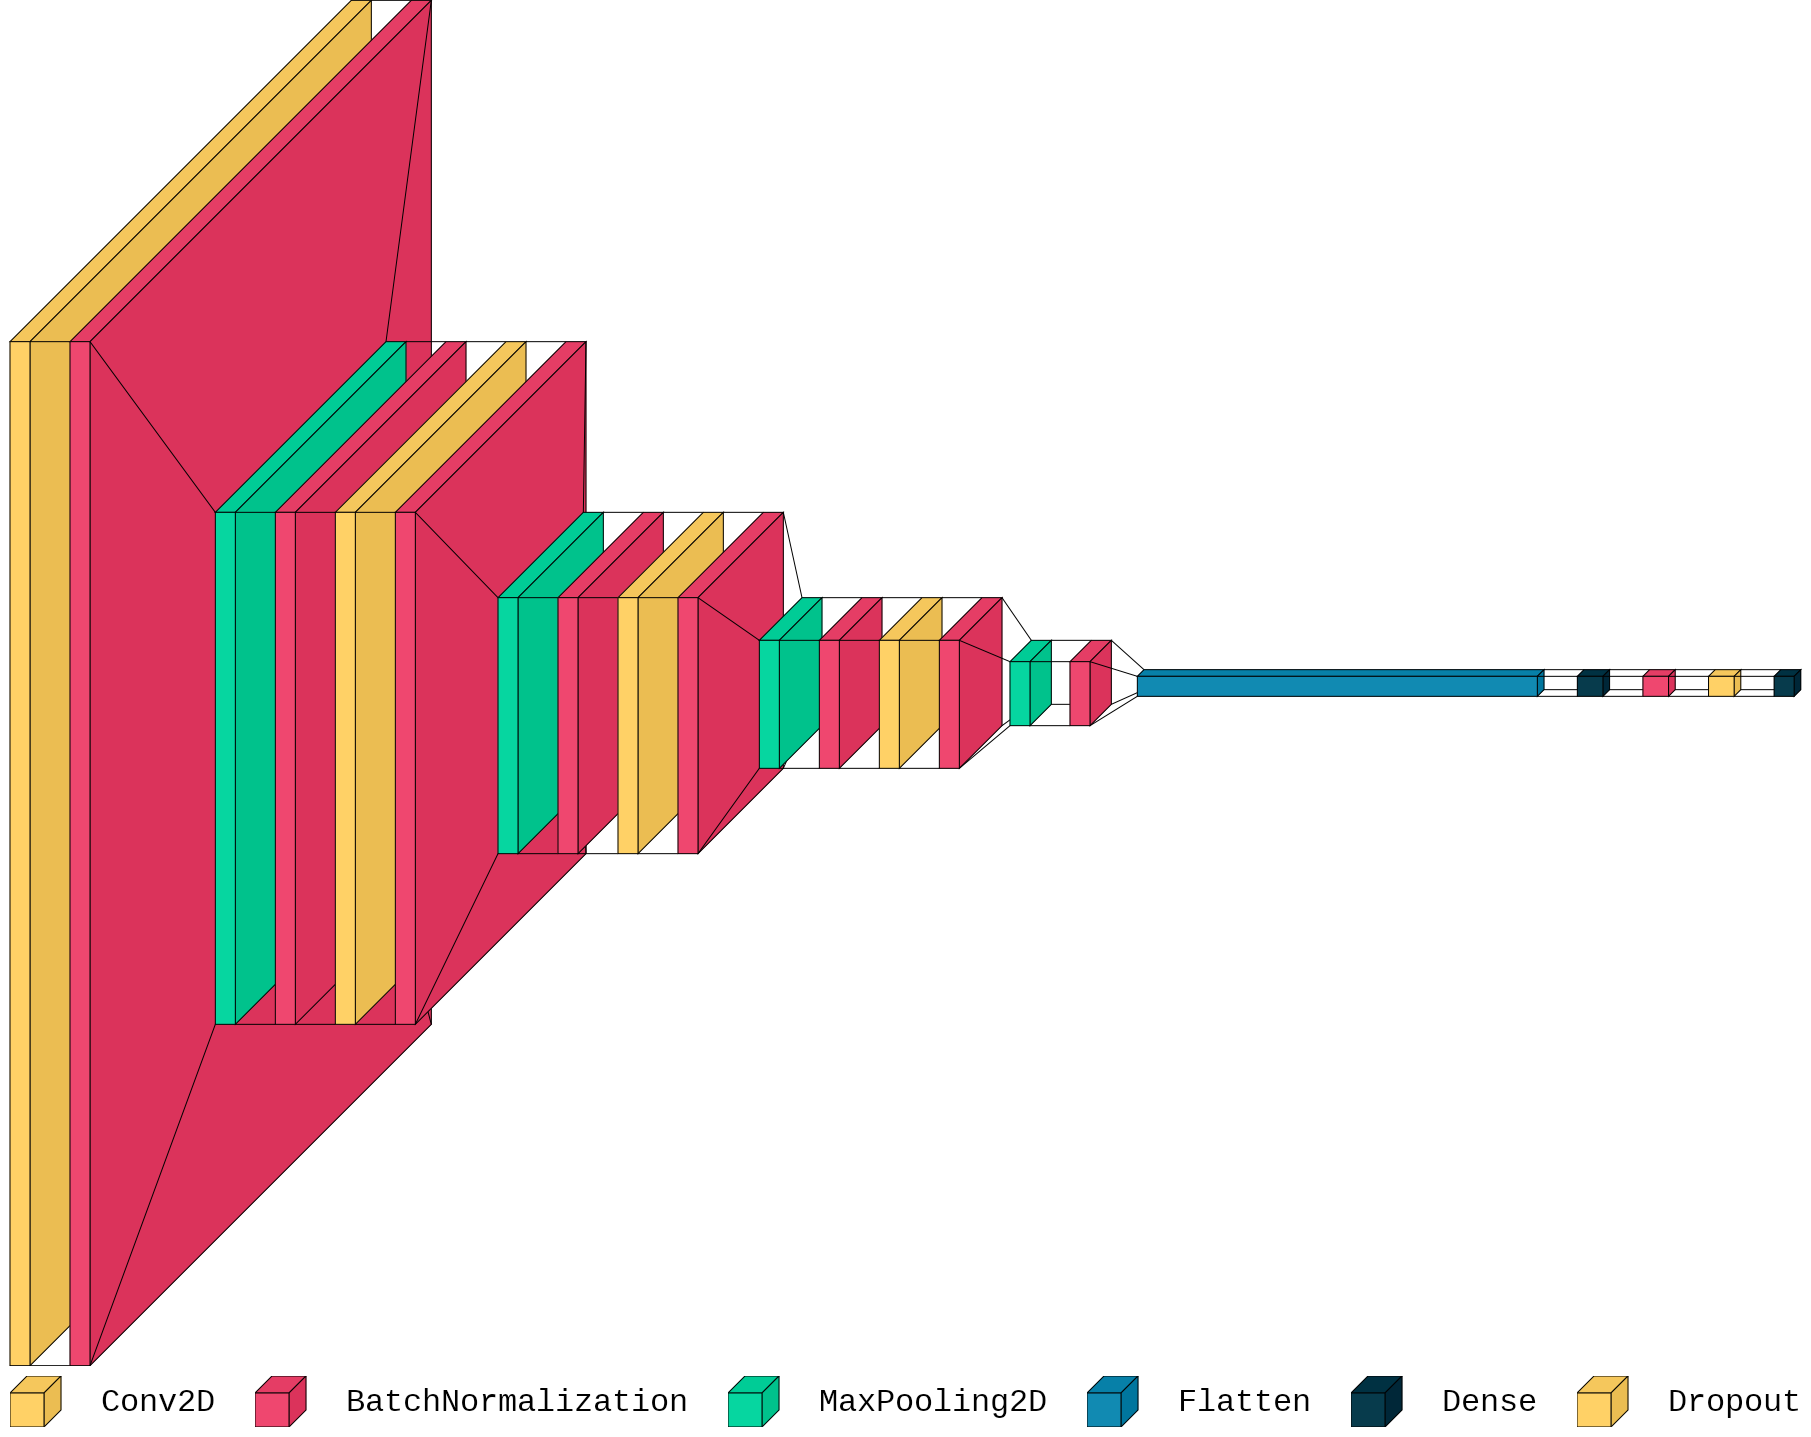

In [441]:
from urllib.request import urlopen
from collections import defaultdict
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D

colormap= plt.get_cmap('tab20')

font_size = 32
font = PIL.ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', font_size)
visualkeras.layered_view(model, legend=True, to_file='CNN_structure.png',spacing=40,font=font,color_map=color_map)